# Spam classification using multinomial naive bayesian classifier

## Table of content
      
       1. Introduction
       2. Data loading
       3. Data processing
          3.1 Tokenization
          3.2 Stopwords removal
          3.3 Lemmatization
          3.4 Vectorization
       4. Model building 
       5. Model evaluation

## Introduction

Multinomial naive bayesian algorithm is a bayes theorem based probabilistic learning method which is widely used in natural language processing. Bayes theorem, formulated by Thomas Bayes, calculates the probability of an event occurring based on the prior knowledge of conditions related to an event. It is based on the following formula:

P(A|B) = P(A) * P(B|A)/P(B)

where,
P(A) = the prior probability of occurring A
P(B) = the probability of occuring B
P(B|A) = the condition probability of B given that A occurs
P(A|B) = the condition probability of A given that B occurs

Using above mentioned algorithm we are classifying the email text as sapm or ham.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import  confusion_matrix 

## Data loading

In [2]:
#Read data
file = pd.read_csv('C:/Users/sreej/Documents/Kaggle/Spam classification/spam.csv',encoding="ISO-8859-1")

The file contains 5572 records. Each record consist of the text and the classification type(spam or harm).

In [3]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Colums Unnamed: 2,Unnamed: 3,Unnamed: 4 are irrelavant features for our model to predict the spam/ham category so to make processing easy we are removing the unwanted colums from the data set. 

In [4]:
file = file.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis = 1)

In [5]:
# Checking if any duplicate records are present
duplicate=file[file.duplicated()] 
duplicate


,v1,v2
102,ham,As per your request 'Melle Melle (Oru Minnamin...
153,ham,As per your request 'Melle Melle (Oru Minnamin...
206,ham,"As I entered my cabin my PA said, '' Happy B'd..."
222,ham,"Sorry, I'll call later"
325,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


In [6]:
# Removing duplicate records
file.drop_duplicates(inplace=True)

In [7]:
file.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
#rename the colums for better understanding 
file.rename(columns = {"v1":"type","v2":"text"},inplace = True)
file.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data processing

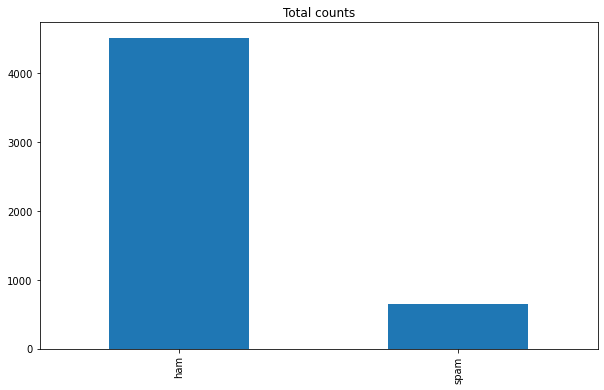

In [9]:
plot = file["type"].value_counts().plot(kind = 'bar', figsize=(10,6),title="Total counts")

In [10]:
#Remove special characters and convert all the text to lower case
def cleansing_data(text):
    cln_text = re.sub('[^a-zA-Z \n\.]', '', text)
    cln_text = cln_text.lower()
    cln_text = cln_text.split()
    cln_text = ''.join(cln_text)
    return cln_text

In [11]:
file["new_text"] = file["text"].apply(cleansing_data)

### Tokenization

Tokenization is the process of breaking the whole paragraph/ sentennce into small tokens. NLTK module has two sub-categories of tokenizers, which are,    
                      word tokenize : tokens sentence into word          
                      sentence tokenize : segmenting paragraph to sentances

In [12]:
file["token"] = [word_tokenize(i) for i in file["new_text"]]


### Stopwords removal 

Stopwords are most commonly used words like 'the','an','in' etc. which doesn't play any role while classifying as spam/ham. To reduce procesing time and database usage, we remove those words from the text. The function 'stopwords.words ('english')' provide all the avilabe stopwords in english.

In [13]:
#Remove stop words
file["filtered_words"] = [word for word in file["token"] if word not in stopwords.words('english')]

### Lemmitization

Lemmitization is the process of retrieving root words from a text. It ensures that the root word belongs to the respective  language, in this case it is English.

In [14]:
def lemmatize_word(text):
    lemma = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemma

In [15]:
lemmatizer = WordNetLemmatizer()
file["lemma_text"] = file["filtered_words"].apply(lemmatize_word) 

### Vectorization

Until this step, all data is in text format. In order to impliment the algorithm, we need to convert the words to numerical format. Vectorization converts  text's to matrix format for further processing.

In [16]:
#Create corpus of text for vectorize those
crp_text = []
for i in file["lemma_text"]:
    msg = ''.join(i) 
    crp_text.append(msg)

#Changing text data in to numbers.

tfidf = TfidfVectorizer()
x = tfidf.fit_transform(crp_text)

## Model building

In [17]:
#Encode the category details 
le = LabelEncoder()
y = le.fit_transform( file["type"])


In [18]:
#Divide the dataset into training and test datasets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20, random_state=42)

In [19]:
#Generate the model 
mnb = MultinomialNB()
#Fit the training data to the generated model
mnb.fit(x_train, y_train)
#Apply test values to the developed model for predicting values
y_pred = mnb.predict(x_test)

## Model evaluation

In [20]:
#Evaluate the model using score functionality 
score = mnb.score(x_test, y_test)
score

0.8752417794970987